In [1]:
from pymongo import MongoClient
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ggplot import *

In [2]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc

(<pyspark.sql.session.SparkSession at 0x7f04dc00dd90>,
 <pyspark.context.SparkContext at 0x7f04e8a838d0>)

### load utility matrix

In [4]:
# load data frame from csv
data_df = pd.read_csv("model_df.csv", sep='\t')

# drop duplicates
data_df = data_df.drop_duplicates(subset=['route_id', 'user_id'])

y_data = data_df[['rating', 'route_id', 'user_id']]
x_data = data_df.drop(['rating', 'route_id', 'user_id', 'member_since'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, random_state=42)

In [5]:
# Convert to a Spark DataFrame
y_train_spark = spark.createDataFrame(y_train)
y_test_spark = spark.createDataFrame(y_test)

### load als model

In [20]:
als_model = ALS(userCol='route_id',
                itemCol='user_id',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
               )
recommender = als_model.fit(y_train_spark)

In [21]:
path = '/home/david/work/project/Rock-Climbing-Route-Recommender/src/alsmodel2'
recommender.save(path)
recommender = ALSModel.load(path)

In [22]:
# Make predictions for the whole test set
predictions = recommender.transform(y_test_spark)

In [23]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()

### grab gradient boosting pickle model

In [24]:
from sklearn.externals import joblib
gb = joblib.load('../pickle/gb_model.pkl') 
gb_predict = gb.predict(X_test)

### fill nulls with gb model prediction

In [25]:
null_ind = pd.isnull(predictions_df).any(1).nonzero()[0]

In [26]:
predictions_df.ix[null_ind, 'prediction'] = gb_predict[null_ind]

In [27]:
predictions_df.head(18)

,rating,route_id,user_id,prediction
0,3,1614,213,2.328690
1,3,1530,1329,2.045483
2,2,2606,1038,1.797803
3,1,1986,2006,0.876302
4,3,2001,604,2.306329
5,4,1319,1742,2.749723
6,3,1865,404,2.691462
7,4,3059,472,3.665307
8,3,1199,1943,3.082814
9,2,287,248,2.379909


In [28]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(y_train['rating'].mean())

In [29]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [30]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.72874976034046413

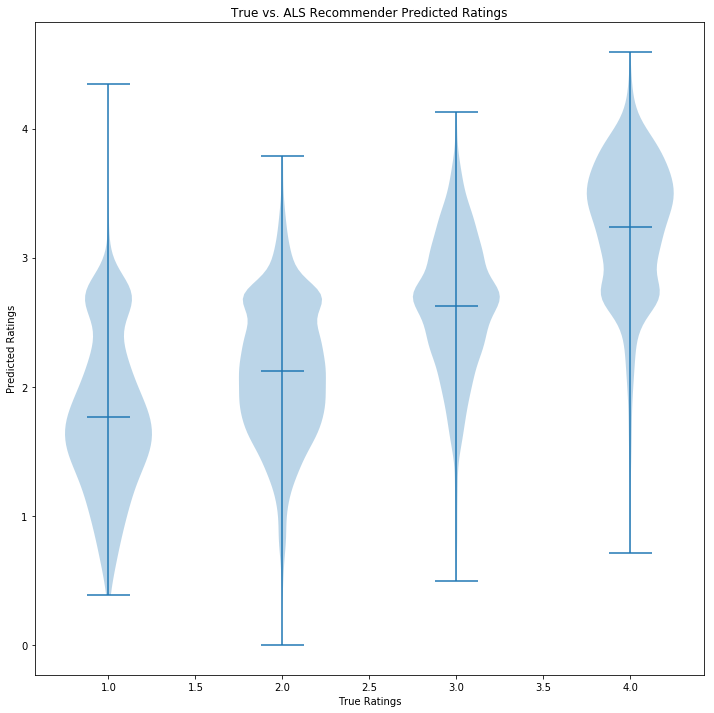

In [31]:
# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(12,12))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

### try weighted

In [32]:
predictions_df['weighted'] = (0.8 * predictions_df['prediction']) + (0.2 * pd.DataFrame(gb_predict)[0])

In [33]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted'])**2

In [34]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.69502988167305002